The following cell defines the right hand side of all of the governing equations (time derivates of the parameters) of the SEIRD system.

In [31]:
%matplotlib widget
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, RadioButtons

def seird_rhs_multi(u, t, params):
    """
    du/dt for multi-group SEIRD with vaccination rollout.

    State layout (for G groups):
        u = [S0,E0,I0,R0,D0,  S1,E1,I1,R1,D1, ...]
    
    params is a dict with:
        beta_mat : (G x G) array, beta_mat[g,h] = transmission from I_h -> S_g
        sigma    : length-G array, incubation rate for group g
        gamma    : length-G array, recovery rate for group g
        mu       : length-G array, mortality rate for group g
        vaccine_rate : function handle vaccine_rate(t, g) giving nu_g(t)
                       (fraction per time vaccinated out of S_g)
    """

    beta_mat   = params["beta_mat"]
    sigma      = params["sigma"]
    gamma      = params["gamma"]
    mu         = params["mu"]
    vaccine_fn = params["vaccine_rate"]

    G = len(sigma)
    du = np.zeros_like(u)

    def idx(g):
        base = 5*g
        return base, base+1, base+2, base+3, base+4  # S,E,I,R,D indices

    # grab all I_h for infection coupling
    I_all = np.array([u[idx(h)[2]] for h in range(G)])

    for g in range(G):
        iS, iE, iI, iR, iD = idx(g)

        Sg = u[iS]
        Eg = u[iE]
        Ig = u[iI]
        Rg = u[iR]
        Dg = u[iD]

        # vaccination rate for this group at this time
        nu_g = vaccine_fn(t, g)  # this can be 0 if group g isn't being vaccinated now

        # force of infection on group g from all h
        infection_rate_g = np.sum(beta_mat[g, :] * Sg * I_all)

        dSdt = -infection_rate_g - nu_g * Sg
        dEdt =  infection_rate_g - sigma[g] * Eg
        dIdt =  sigma[g] * Eg - (gamma[g] + mu[g]) * Ig
        dRdt =  gamma[g] * Ig + nu_g * Sg
        dDdt =  mu[g] * Ig

        du[iS] = dSdt
        du[iE] = dEdt
        du[iI] = dIdt
        du[iR] = dRdt
        du[iD] = dDdt

    return du



This cell shows the RK4 method in code. 

In [62]:
def rk4_step(u, t, dt, params, rhs_func):
        k1 = rhs_func(u,               t,               params)
        k2 = rhs_func(u + 0.5*dt*k1,   t + 0.5*dt,      params)
        k3 = rhs_func(u + 0.5*dt*k2,   t + 0.5*dt,      params)
        k4 = rhs_func(u + dt*k3,       t + dt,          params)

        return u + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

This cell combines the two functions above to finish the rk4 method. It returns the values of each population at each time interval. 

In [33]:
def method(delta_t, vaccine_rate, beta_multiplier, incubation_period=5, infectious_period=14):
    G = 3 # number of groups
    sigma = np.array([1/incubation_period, 1/incubation_period, 1/incubation_period])      # incubation
    gamma = np.array([1/infectious_period, 1/infectious_period, 1/infectious_period])   # recovery, the denominator is the total amount of days that the person is infected for

    mu    = np.array([0.0005,0.002,0.0005])   # mortality per group, this is the percentage chance every day that the infected will die, so we take the known fatality rate of the disease and divide it by the amount of days they are infected

    R0_group = np.array([3*0.8, 1.5*0.8, 2*0.8]) * beta_multiplier ###infections caused by each new infected person, differs between groups

    beta_per_group = R0_group * (gamma + mu)

    beta_mat = np.tile(beta_per_group, (G, 1))

    params = {
        "beta_mat": beta_mat,
        "sigma":    sigma,
        "gamma":    gamma,
        "mu":       mu,
        "vaccine_rate": vaccine_rate  # <- our rollout policy function
    }

    # Define group populations (fractions of the total)
    pop_fracs = np.array([0.4, 0.2, 0.4])  # group 0, group 1, group 2

    # Define how much of each group starts in each state
    E_seed = 1e-3  # * 100 = % of initially exposed people
    u0 = []

    for g in range(3):
        Sg = pop_fracs[g] - E_seed  # everyone starts susceptible except tiny exposed
        Eg = E_seed
        Ig = 0.0
        Rg = 0.0
        Dg = 0.0
        u0.extend([Sg, Eg, Ig, Rg, Dg])

    u0 = np.array(u0, dtype=float)

    # normalize across all groups to make sure the sum = 1
    u0 /= np.sum(u0)
    t0 = 0.0
    T  = 250
    dt = delta_t
    N  = int((T - t0)/dt)

    t_vals = np.linspace(t0, T, N+1)
    u_vals = np.zeros((N+1, len(u0)))
    u_vals[0] = u0

    u = u0.copy()
    t = t0

    for k in range(N):
        u = rk4_step(u, t, dt, params, seird_rhs_multi)
        t += dt
        u_vals[k+1] = u

    u_reshaped = u_vals.reshape(len(t_vals), G, 5)  # axis2 = [S,E,I,R,D]

    # total population in each compartment
    S_total = np.sum(u_reshaped[:, :, 0] * pop_fracs[np.newaxis, :], axis=1)
    E_total = np.sum(u_reshaped[:, :, 1] * pop_fracs[np.newaxis, :], axis=1)
    I_total = np.sum(u_reshaped[:, :, 2] * pop_fracs[np.newaxis, :], axis=1)
    R_total = np.sum(u_reshaped[:, :, 3] * pop_fracs[np.newaxis, :], axis=1)
    D_total = np.sum(u_reshaped[:, :, 4] * pop_fracs[np.newaxis, :], axis=1)
    return S_total, E_total, I_total, R_total, D_total

This cell is used to define the specifics of the desired vaccination strategies for the model. It allows us to change which group recieves the vaccine, at what rate that happens, and how long into the simulation this will begin.

In [124]:
def vaccine_rate_no_vax(t, g): # no vaccination
    return 0.0 

def vaccine_rate_delayed_rollout(t, g): # vaccination starts after delay
    if t < 50:
        return 0.0
    else:
        rates = [0.03, 0.03, 0.03]  # group 0, group 1, group 2
        return rates[g] # vaccination rates after delay of 50 days

def vaccine_rate_early_rollout(t, g): # vaccination starts early
    if t < 20:
        return 0.0
    else:
        rates = [0.03, 0.03, 0.03]  # group 0, group 1, group 2
        return rates[g] 

def vaccine_rate_targeted_spreaders(t, g): # targeted vaccination of group 1 first
    if t < 20:
        return 0.0
    elif 20 <= t < 80:
        rates = [0.05, 0.0, 0.0]  # only group 1 vaccinated
        return rates[g]
    else:
        rates = [0.03, 0.03, 0.03]  # all groups vaccinated
        return rates[g]

def vaccine_rate_targeted_vulnrable(t, g): #targeted vaccination of group 2 first
    if t < 20:
        return 0.0
    elif 20 <= t < 80:
        rates = [0.00, 0.05, 0.00]  # only group 0 and 2 vaccinated
        return rates[g]
    else:
        rates = [0.03, 0.03, 0.03]  # all groups vaccinated
        return rates[g]
    

def vaccine_rate_campaigns(t, g): # vaccination in campaigns
    if 30 <= t < 60:
        rates = [0.03, 0.03, 0.03] # group 0, group 1, group 2
        return rates[g]
    elif 120 <= t < 150:
        rates = [0.03, 0.03, 0.03] # group 0, group 1, group 2
        return rates[g]
    else:
        return 0.0

This next cell gives us an interactive graph of the method, where you can change the vaccination method and social distancing measures. 

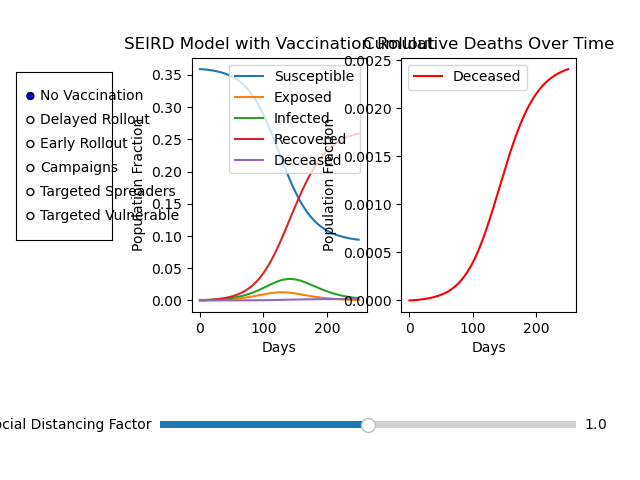

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.subplots_adjust(left=0.25, bottom=0.35)
axTotal, axDeath = ax.flat
ax1 = plt.axes([0.25, 0.1, 0.65, 0.03])
ax2 = plt.axes([0.025, 0.5, 0.15, 0.35])

slider = Slider(ax1, 'Social Distancing Factor', 0.5, 1.5, valinit=1.0)
Button = RadioButtons(ax2, ('No Vaccination', 'Delayed Rollout', 'Early Rollout', 'Campaigns','Targeted Spreaders','Targeted Vulnerable'), active=0)
def update(val):
    beta_multiplier = slider.val
    choice = Button.value_selected

    if choice == 'No Vaccination':
        vaccine_fn = vaccine_rate_no_vax
    elif choice == 'Delayed Rollout':
        vaccine_fn = vaccine_rate_delayed_rollout
    elif choice == 'Early Rollout':
        vaccine_fn = vaccine_rate_early_rollout
    elif choice == 'Campaigns':
        vaccine_fn = vaccine_rate_campaigns
    elif choice == 'Targeted Spreaders':
        vaccine_fn = vaccine_rate_targeted_spreaders
    elif choice == 'Targeted Vulnerable':
        vaccine_fn = vaccine_rate_targeted_vulnrable

    S, E, I, R, D = method(1.0, vaccine_fn, beta_multiplier)

    ax = axTotal
    ax.clear()
    ax.plot(S, label='Susceptible')
    ax.plot(E, label='Exposed')
    ax.plot(I, label='Infected')
    ax.plot(R, label='Recovered')
    ax.plot(D, label='Deceased')
    ax.set_xlabel('Days')
    ax.set_ylabel('Population Fraction')
    ax.legend()
    ax.set_title('SEIRD Model with Vaccination Rollout')
    ax = axDeath
    ax.clear()
    ax.plot(D, color='red', label='Deceased')
    ax.set_xlabel('Days')
    ax.set_ylabel('Population Fraction')
    ax.set_title('Cumulative Deaths Over Time')
    ax.legend()
    fig.canvas.draw_idle()
slider.on_changed(update)
Button.on_clicked(update)
update(None)
plt.show()



This next code block shows the convergence of the RK4 method on the SEIRD model. We can use this to determine an accurate times step to use. 

<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\D'
C:\Users\aeron\AppData\Local\Temp\ipykernel_12952\826162172.py:23: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta t$')


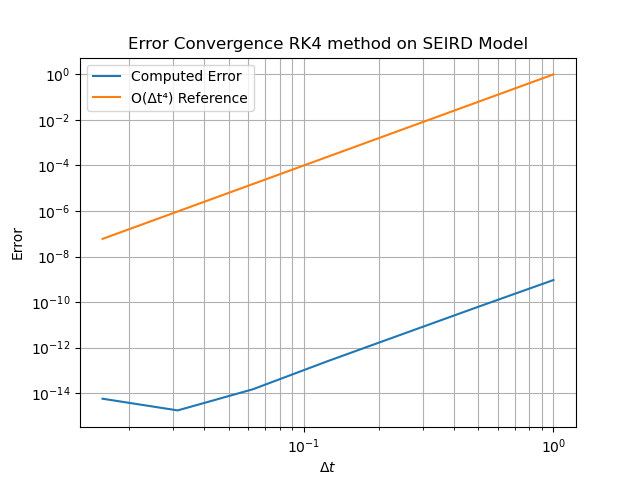

In [122]:
delta_ts = []
finals = []
delta_t = 1.0
for i in range(8):
    S_total, E_total, I_total, R_total, D_total = method(delta_t, vaccine_rate_no_vax, 1.0)
    finals.append(np.array([S_total[-1], E_total[-1], I_total[-1], R_total[-1], D_total[-1]]))
    delta_ts.append(delta_t)
    delta_t /= 2.0

err = []
for i in range(len(finals) - 1):
    error = la.norm(finals[i] - finals[-1], 2)
    err.append(error / la.norm(finals[-1],2))

finals.pop()
delta_ts.pop()

calc_err = [delta_t**4 for delta_t in delta_ts]  # RK4 is 4th order

fig = plt.figure()
plt.loglog(delta_ts, err, label='Computed Error')
plt.loglog(delta_ts, calc_err, label='O(Δt⁴) Reference')
plt.xlabel('$\Delta t$')  
plt.ylabel('Error')
plt.title('Error Convergence RK4 method on SEIRD Model')
plt.grid(True, which='both')
plt.legend()
plt.show()

Below we have a convergence study on a different ODE. We know the solution to this problem, so we can use that to model our true error. 

<>:41: SyntaxWarning: invalid escape sequence '\D'
<>:41: SyntaxWarning: invalid escape sequence '\D'
C:\Users\aeron\AppData\Local\Temp\ipykernel_12952\2300361701.py:41: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta t$')


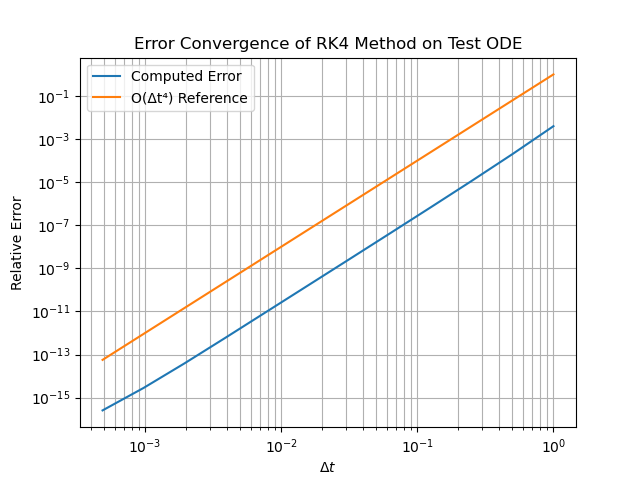

In [123]:
delta_ts = []
finals = []
delta_t = 1.0

def test_rhs(u, t, params):
    return np.array([-0.5 * u[0]])
def test_method(delta_t):
    u0 = np.array([1.0])
    t0 = 0.0
    T  = 10.0
    dt = delta_t
    N  = int((T - t0)/dt)

    t = t0
    u = u0.copy()

    for k in range(N):
        u = rk4_step(u, t, dt, {}, test_rhs)
        t += dt

    return u
def compute_error(u_final):
    u_exact = np.array([np.exp(-0.5 * 10.0)])  # exact solution at T=10
    return la.norm(u_final - u_exact) / la.norm(u_exact)
for i in range(12):
    delta_ts.append(delta_t)
    final = test_method(delta_t)
    finals.append(final)
    delta_t /= 2.0


err = []
for final in finals:
    err.append(compute_error(final))

calc_err = [delta_t**4 for delta_t in delta_ts]  # RK4 is 4th order

fig = plt.figure()
plt.loglog(delta_ts, err, label='Computed Error')
plt.loglog(delta_ts, calc_err, label='O(Δt⁴) Reference')
plt.xlabel('$\Delta t$')  
plt.ylabel('Relative Error')
plt.title('Error Convergence of RK4 Method on Test ODE')
plt.grid(True, which='both')
plt.legend()
plt.show()